In [1]:

# IMPORTS AND GLOBAL SETUP

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

# Determine the device to use (GPU if available, otherwise CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
EPOCHS = 10
BATCH_SIZE = 64

# Indices for similar apparel (Tops/Outerwear: 0, 2, 3, 4, 6) for focused confusion analysis
TARGET_CONFUSION_INDICES = [0, 2, 3, 4, 6]

Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.9MB/s]


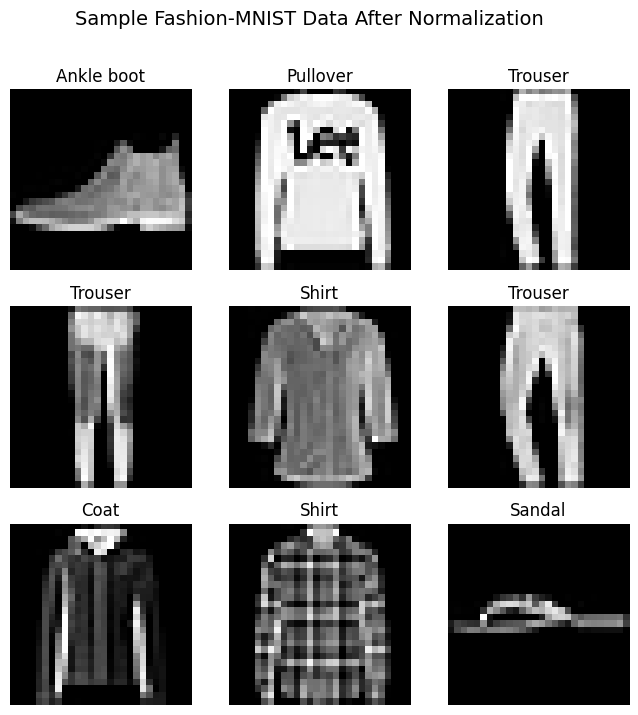

In [2]:
# DATA LOADING AND PREPARATION


# Standard transformation pipeline: ToTensor (scales to [0, 1]), then Normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset_full = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Split training data into training (90%) and validation (10%) sets
train_indices, val_indices = train_test_split(
    range(len(train_dataset_full)),
    test_size=0.1,
    random_state=42,
    stratify=train_dataset_full.targets.numpy()
)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(train_dataset_full, val_indices)

# DataLoaders for efficient batch processing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Function to display un-normalized image for visualization
def imshow_normalized(img):
    # Un-normalize the image (reverse of Normalize((0.5,), (0.5,)))
    img = img / 2 + 0.5
    npimg = img.numpy()
    # Rearrange dimensions from PyTorch (C, H, W) to Matplotlib (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')

# Display a sample of the data
dataiter = iter(test_loader)
images, labels = next(dataiter)

plt.figure(figsize=(8,8))
plt.suptitle('Sample Fashion-MNIST Data After Normalization', fontsize=14)
for i in range(9):
    plt.subplot(3,3,i+1)
    imshow_normalized(images[i])
    plt.title(class_names[labels[i].item()])
    plt.axis('off')
plt.show()

In [3]:
# ANN & CNN MODEL DEFINITION


# ANN MODEL DEFINITION
class ANN(nn.Module):
    """
    Artificial Neural Network (Multi-Layer Perceptron) for classification.
    """
    def __init__(self):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Input size: 784 (28*28)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)         # Output size: 10 classes
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.fc_layers(x)


 ANN Model Structure
ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

 CNN Model Structure
SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=10, bias=True)
  )
)


In [ ]:
# CNN MODEL DEFINITION
class SimpleCNN(nn.Module):
    """
    Simple Convolutional Neural Network for image classification.
    """
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Conv layer 1: Input (1x28x28) -> Output (32x14x14)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Conv layer 2: Input (32x14x14) -> Output (64x7x7)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 10) # 64 channels * 7*7 spatial size -> 10 classes
        )
    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

ann_model = ANN().to(DEVICE)
cnn_model = SimpleCNN().to(DEVICE)

print("\n ANN Model Structure")
print(ann_model)
print("\n CNN Model Structure")
print(cnn_model)


In [4]:
# SHARED TRAINING AND EVALUATION FUNCTIONS


def evaluate_model(model, data_loader):
    """Evaluates the model on a given DataLoader, returning accuracy, loss, and predictions."""
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = correct / total
    avg_loss = running_loss / total
    return accuracy, avg_loss, y_true, y_pred


def train_and_evaluate(model, train_loader, val_loader, test_loader, epochs, model_name):
    """Trains the model and tracks per-epoch metrics."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    final_train_acc = 0.0
    final_val_acc = 0.0

    print(f"\n Starting Training for {model_name} Model ")

    for epoch in range(epochs):
        # TRAINING PHASE
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_correct / train_total
        final_train_acc = epoch_train_acc # Update final train accuracy

        # VALIDATION PHASE
        val_acc, val_loss, _, _ = evaluate_model(model, val_loader)
        final_val_acc = val_acc # Store final validation accuracy (last epoch)

        # Store metrics
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print all four metrics per epoch
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Final Testing phase
    test_acc, _, y_true, y_pred = evaluate_model(model, test_loader)
    print(f"\n{model_name} Final Test Accuracy: {test_acc:.4f}")

    # Return history and final train/val/test accuracies
    return history, final_train_acc, final_val_acc, test_acc, y_true, y_pred

# Prediction Plotting Function (UPDATED for Confidence Score)
def plot_predictions(model, test_loader, class_names, num_images=9, title='Model Predictions'):
    """Plots sample test images with true and predicted labels and confidence scores."""
    model.eval()

    # Get a batch of data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        # Get the predicted class index
        _, predicted = torch.max(outputs, 1)

        # Calculate probabilities using softmax
        probabilities = torch.softmax(outputs, dim=1)

        # Get the confidence score for the predicted class
        confidences = probabilities.gather(1, predicted.view(-1, 1)).squeeze().cpu().numpy()


    plt.figure(figsize=(9, 9))
    plt.suptitle(title, fontsize=16)

    for i in range(num_images):
        plt.subplot(3, 3, i + 1)

        imshow_normalized(images[i].cpu())

        true_label = class_names[labels[i].item()]
        pred_label = class_names[predicted[i].item()]
        confidence = confidences[i] * 100 # Convert to percentage

        # Set color based on correctness
        color = 'blue' if true_label == pred_label else 'red'

        # Display confidence score
        title_text = (
            f"True: {true_label}\n"
            f"Pred: {pred_label} ({confidence:.1f}%)"
        )

        plt.title(title_text, color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Confusion Matrix Plotting Function
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """Plots a heatmap of the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='YlGnBu',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Filtered Confusion Matrix Plotting Function
def plot_filtered_confusion_matrix(y_true, y_pred, class_names, target_indices, title):
    """
    Plots a confusion matrix heatmap, filtered to show only interactions
    between a specific subset of target classes (by index).

    The resulting matrix shows true labels (rows) vs. predicted labels (columns)
    only for the classes defined in target_indices.
    """
    # 1. Calculate the full confusion matrix
    full_cm = confusion_matrix(y_true, y_pred)

    # 2. Select the relevant rows and columns using the target indices
    target_rows = list(target_indices)
    target_cols = list(target_indices)

    # Extract the sub-matrix
    sub_cm = full_cm[np.ix_(target_rows, target_cols)]

    # Get the names for the filtered classes
    filtered_class_names = [class_names[i] for i in target_indices]

    # 3. Plot the sub-matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        sub_cm,
        annot=True,
        fmt='d',
        cmap='Reds', # Use a different color map for contrast
        xticklabels=filtered_class_names,
        yticklabels=filtered_class_names
    )
    plt.title(f'Filtered Confusion Matrix: {title} (Focus: Tops/Outerwear)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Line Graph Plotting Function
def plot_all_metrics(ann_h, cnn_h, ann_test_acc, cnn_test_acc):
    """Plots training and validation loss/accuracy over epochs."""
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    epochs_range = range(1, EPOCHS + 1)

    # Plot Loss
    axs[0].plot(epochs_range, ann_h['train_loss'], label='ANN Train Loss')
    axs[0].plot(epochs_range, ann_h['val_loss'], label='ANN Val Loss', linestyle='--')
    axs[0].plot(epochs_range, cnn_h['train_loss'], label='CNN Train Loss')
    axs[0].plot(epochs_range, cnn_h['val_loss'], label='CNN Val Loss', linestyle='--')
    axs[0].set_title('Training and Validation Loss Comparison')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy
    axs[1].plot(epochs_range, ann_h['train_acc'], label=f'ANN Train Acc')
    axs[1].plot(epochs_range, ann_h['val_acc'], label=f'ANN Val Acc (Test: {ann_test_acc:.3f})', linestyle='--')
    axs[1].plot(epochs_range, cnn_h['train_acc'], label=f'CNN Train Acc')
    axs[1].plot(epochs_range, cnn_h['val_acc'], label=f'CNN Val Acc (Test: {cnn_test_acc:.3f})', linestyle='--')
    axs[1].set_title('Training and Validation Accuracy Comparison')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].grid(True)

    plt.show()

# Bar Chart Plotting Function (FOR FINAL COMPARISON)
def plot_accuracy_comparison_bar(ann_accs, cnn_accs):
    """Plots a grouped bar chart comparing train, val, and test accuracies."""
    # Prepare data for plotting
    data = [
        {'Metric': 'Train Accuracy', 'ANN (MLP)': ann_accs[0], 'Simple CNN': cnn_accs[0]},
        {'Metric': 'Validation Accuracy', 'ANN (MLP)': ann_accs[1], 'Simple CNN': cnn_accs[1]},
        {'Metric': 'Test Accuracy', 'ANN (MLP)': ann_accs[2], 'Simple CNN': cnn_accs[2]}
    ]
    df = pd.DataFrame(data).set_index('Metric')

    # Plotting
    ax = df.plot(kind='bar', figsize=(10, 6), rot=0, color=['#1f77b4', '#ff7f0e'])

    plt.title('Train, Validation, and Test Accuracy Comparison', fontsize=16)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Data Split', fontsize=12)
    plt.ylim(0.7, 1.0) # Set Y-axis for better visual comparison

    # Add values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    plt.legend(title='Model')
    plt.grid(axis='y', linestyle='--')
    plt.show()

In [5]:
# ANN MODEL TRAINING


# Train and Evaluate ANN Model
print("\n ANN Model Training and Metrics")
ann_history, ann_train_acc, ann_val_acc, ann_test_acc, ann_y_true, ann_y_pred = train_and_evaluate(
    ann_model, train_loader, val_loader, test_loader, EPOCHS, "ANN"
)


--- 5. ANN Model Training and Metrics ---

 Starting Training for ANN Model 
Epoch 1/10 | Train Loss: 0.5342, Train Acc: 0.8061 | Val Loss: 0.3979, Val Acc: 0.8557
Epoch 2/10 | Train Loss: 0.3875, Train Acc: 0.8584 | Val Loss: 0.3738, Val Acc: 0.8620
Epoch 3/10 | Train Loss: 0.3473, Train Acc: 0.8723 | Val Loss: 0.3378, Val Acc: 0.8752
Epoch 4/10 | Train Loss: 0.3203, Train Acc: 0.8813 | Val Loss: 0.3290, Val Acc: 0.8780
Epoch 5/10 | Train Loss: 0.3045, Train Acc: 0.8868 | Val Loss: 0.3156, Val Acc: 0.8870
Epoch 6/10 | Train Loss: 0.2875, Train Acc: 0.8935 | Val Loss: 0.3167, Val Acc: 0.8847
Epoch 7/10 | Train Loss: 0.2727, Train Acc: 0.8974 | Val Loss: 0.3043, Val Acc: 0.8865
Epoch 8/10 | Train Loss: 0.2614, Train Acc: 0.9014 | Val Loss: 0.3053, Val Acc: 0.8928
Epoch 9/10 | Train Loss: 0.2510, Train Acc: 0.9065 | Val Loss: 0.3029, Val Acc: 0.8927
Epoch 10/10 | Train Loss: 0.2396, Train Acc: 0.9103 | Val Loss: 0.2884, Val Acc: 0.8983

ANN Final Test Accuracy: 0.8818



 ANN Confusion Matrix 


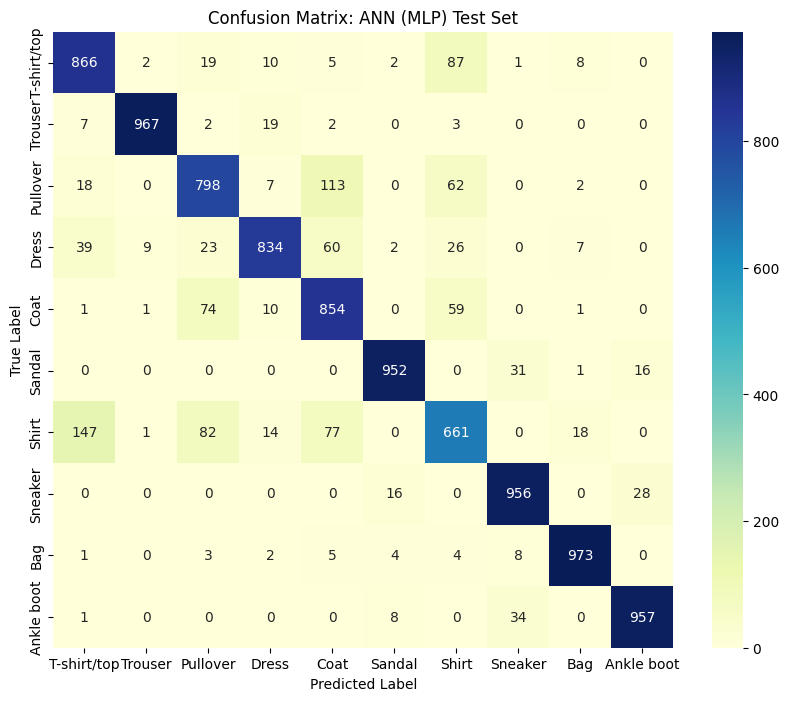

In [6]:
# ANN CONFUSION MATRIX


# Display ANN Confusion Matrix
print("\n ANN Confusion Matrix ")
plot_confusion_matrix(ann_y_true, ann_y_pred, class_names, 'ANN (MLP) Test Set')

In [7]:
# ANN CLASSIFICATION REPORT


# Display ANN Classification Report
print("\n ANN Classification Report ")
print(classification_report(ann_y_true, ann_y_pred, target_names=class_names))


 ANN Classification Report 
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.87      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.80      0.80      0.80      1000
       Dress       0.93      0.83      0.88      1000
        Coat       0.77      0.85      0.81      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.73      0.66      0.70      1000
     Sneaker       0.93      0.96      0.94      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000




 ANN Sample Predictions (Visual Results) 


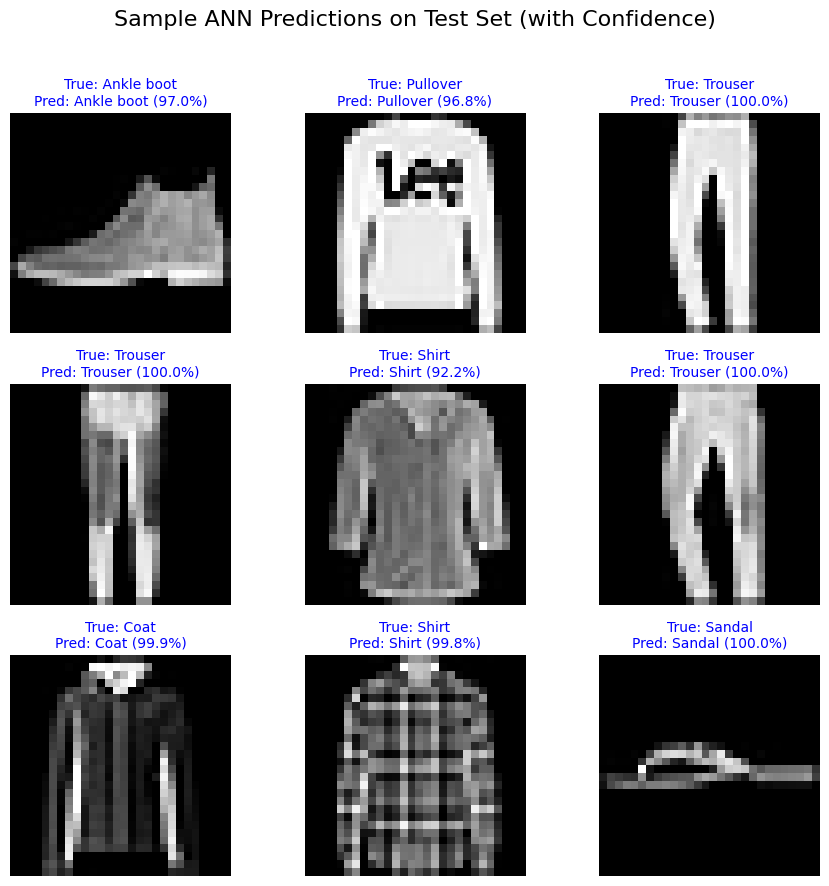

In [8]:
# ANN SAMPLE PREDICTIONS (RESULTS)


# Display ANN Sample Predictions
print("\n ANN Sample Predictions (Visual Results) ")
plot_predictions(ann_model, test_loader, class_names, title='Sample ANN Predictions on Test Set (with Confidence)')

In [9]:
#  CNN MODEL TRAINING


# Train and Evaluate CNN Model
print("\n CNN Model Training and Metrics ")
cnn_history, cnn_train_acc, cnn_val_acc, cnn_test_acc, cnn_y_true, cnn_y_pred = train_and_evaluate(
    cnn_model, train_loader, val_loader, test_loader, EPOCHS, "CNN"
)


 CNN Model Training and Metrics 

 Starting Training for CNN Model 
Epoch 1/10 | Train Loss: 0.4487, Train Acc: 0.8394 | Val Loss: 0.3035, Val Acc: 0.8947
Epoch 2/10 | Train Loss: 0.2954, Train Acc: 0.8951 | Val Loss: 0.2594, Val Acc: 0.9045
Epoch 3/10 | Train Loss: 0.2525, Train Acc: 0.9090 | Val Loss: 0.2480, Val Acc: 0.9122
Epoch 4/10 | Train Loss: 0.2245, Train Acc: 0.9196 | Val Loss: 0.2235, Val Acc: 0.9190
Epoch 5/10 | Train Loss: 0.2038, Train Acc: 0.9264 | Val Loss: 0.2200, Val Acc: 0.9213
Epoch 6/10 | Train Loss: 0.1841, Train Acc: 0.9341 | Val Loss: 0.2228, Val Acc: 0.9198
Epoch 7/10 | Train Loss: 0.1724, Train Acc: 0.9382 | Val Loss: 0.2180, Val Acc: 0.9225
Epoch 8/10 | Train Loss: 0.1547, Train Acc: 0.9445 | Val Loss: 0.2307, Val Acc: 0.9173
Epoch 9/10 | Train Loss: 0.1445, Train Acc: 0.9488 | Val Loss: 0.2224, Val Acc: 0.9230
Epoch 10/10 | Train Loss: 0.1315, Train Acc: 0.9536 | Val Loss: 0.2243, Val Acc: 0.9258

CNN Final Test Accuracy: 0.9125



 CNN Confusion Matrix 


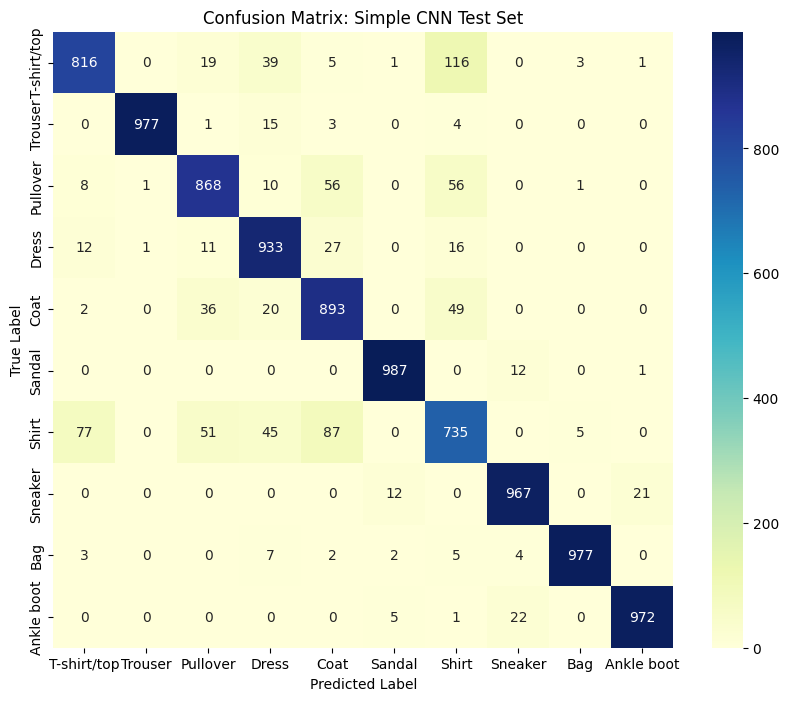

In [10]:
# CNN CONFUSION MATRIX


# Display CNN Confusion Matrix
print("\n CNN Confusion Matrix ")
plot_confusion_matrix(cnn_y_true, cnn_y_pred, class_names, 'Simple CNN Test Set')

In [11]:
# CNN CLASSIFICATION REPORT


# Display CNN Classification Report
print("\n CNN Classification Report")
print(classification_report(cnn_y_true, cnn_y_pred, target_names=class_names))


 CNN Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.82      0.85      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.88      0.87      0.87      1000
       Dress       0.87      0.93      0.90      1000
        Coat       0.83      0.89      0.86      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.75      0.73      0.74      1000
     Sneaker       0.96      0.97      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000




 CNN Sample Predictions (Visual Results)


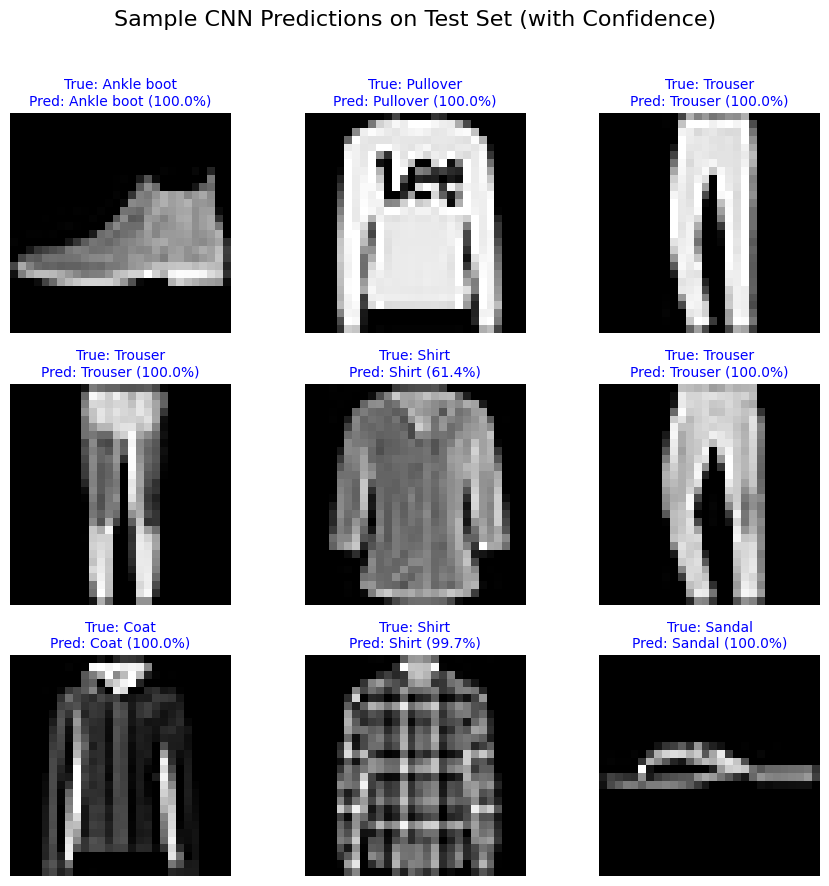

In [12]:
# CNN SAMPLE PREDICTIONS (RESULTS)


# Display CNN Sample Predictions
print("\n CNN Sample Predictions (Visual Results)")
plot_predictions(cnn_model, test_loader, class_names, title='Sample CNN Predictions on Test Set (with Confidence)')


 Final Comparative Analysis Plots 


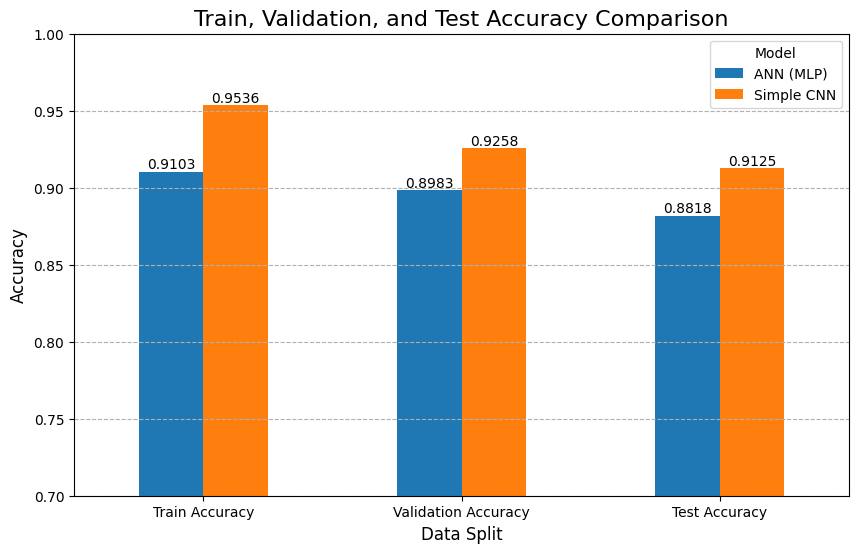

In [16]:
#  FINAL COMPARATIVE ANALYSIS PLOTS

print("\n Final Comparative Analysis Plots ")

# Data for the Bar Chart
ann_accs = [ann_train_acc, ann_val_acc, ann_test_acc]
cnn_accs = [cnn_train_acc, cnn_val_acc, cnn_test_acc]

# Plot Bar Chart (Train/Val/Test Accuracy Comparison)
plot_accuracy_comparison_bar(ann_accs, cnn_accs)




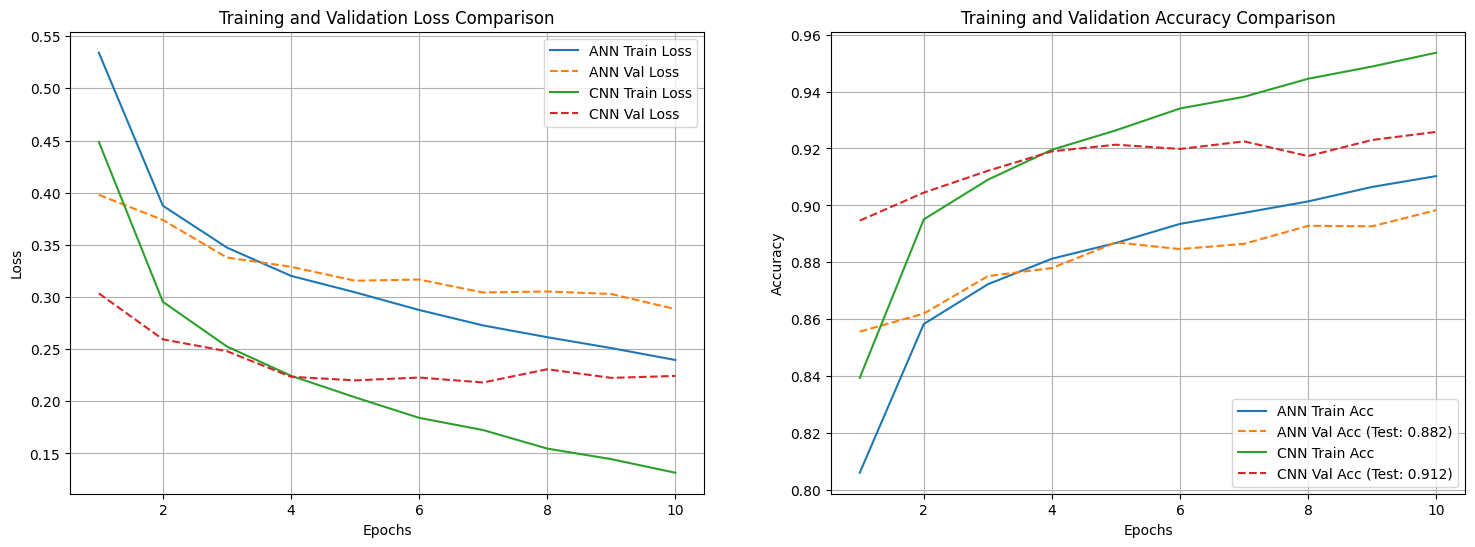

In [17]:
# Plot Line Graphs (Loss/Accuracy over Epochs)
plot_all_metrics(ann_history, cnn_history, ann_test_acc, cnn_test_acc)

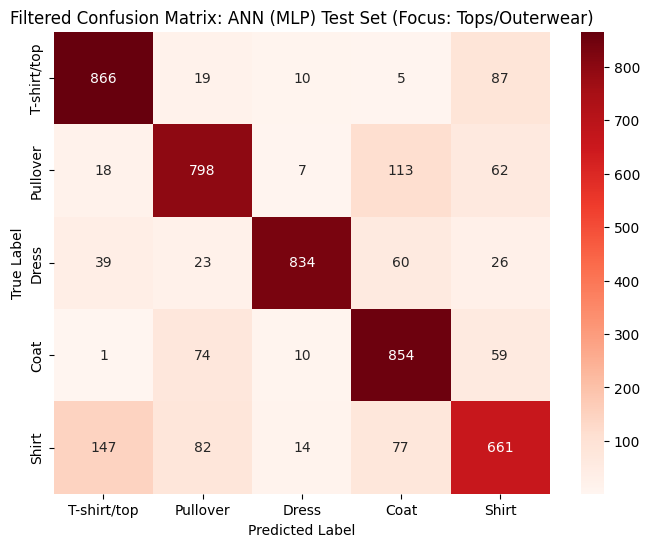

In [20]:
# --- Focused Confusion Matrix for Similar Classes ---

# Plot for ANN
plot_filtered_confusion_matrix(
    ann_y_true,
    ann_y_pred,
    class_names,
    TARGET_CONFUSION_INDICES,
    'ANN (MLP) Test Set'
)

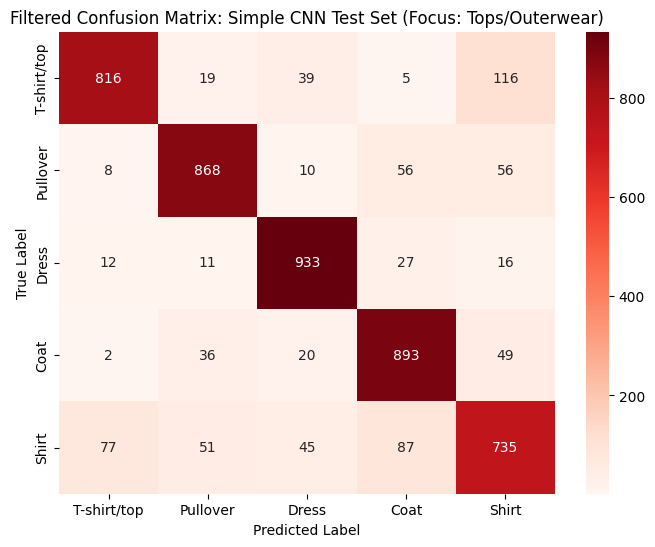

In [19]:
# Plot for CNN
plot_filtered_confusion_matrix(
    cnn_y_true,
    cnn_y_pred,
    class_names,
    TARGET_CONFUSION_INDICES,
    'Simple CNN Test Set'
)